In [1]:
import nltk
import torch
import torch.nn as nn
import urllib.request
import bs4
import string
import matplotlib.pyplot as plt

In [3]:
scrapped_data = urllib.request.urlopen('https://en.wikipedia.org/wiki/French_Revolution')
article = scrapped_data.read()

parsed_article = bs4.BeautifulSoup(article,'lxml')
paragraphs = parsed_article.find_all("p")

articles = ""

for p in paragraphs:
    articles += p.text
    
train_data = articles.translate(str.maketrans('','',string.punctuation)).lower()
train_data = train_data.translate(str.maketrans('','',string.digits))

text = nltk.word_tokenize(train_data)
stop_words = set(nltk.corpus.stopwords.words('english'))

text = [words for words in text if words not in stop_words]

In [4]:
# text = "natural language processing and machine learning is fun and exciting"
# text = nltk.word_tokenize(text) # returns a list
# stop_words = set(nltk.corpus.stopwords.words('english'))
# text = [word for word in text if word not in stop_words]

vocab_size = len(text)
vocab_size

10625

In [5]:
# this is the code for choosing the words

window = 2
ls = []

for center_index in range(vocab_size):
    
    for sub in range(max(0, center_index - window), center_index):
        ls.append((center_index, sub))
        
    for add in range(center_index + 1, min(vocab_size - 1, center_index + window)+1):
        ls.append((center_index, add))

In [6]:
word2int = {}
int2word = {}
key = 0

for word in text:
    if word not in word2int:
        word2int.update({word : key})
        int2word.update({key : word})
        key += 1

In [47]:
class Model(nn.Module):
    def __init__(self, vocab_size, embedding_size):
        super(Model, self).__init__()
        
        self.embeddings_target = nn.Embedding(vocab_size, embedding_size)
        self.embeddings_context = nn.Embedding(vocab_size, embedding_size)
    
    
    def forward(self, target_index):
        
        target = self.embeddings_target(torch.LongTensor([target_index])).reshape(-1)
        # select the embedding for the center word
        
        numerator = torch.zeros(vocab_size)
        for i in range(vocab_size):
            if i != target_index:
                context = self.embeddings_context(torch.LongTensor([i])).reshape(-1)
                numerator[i] = torch.matmul(target, context)
        
        score = F.log_softmax(numerator)
        
        return score
        

model = Model(vocab_size, 150).cuda()      

In [29]:
learning_rate = 0.003

optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
lossfn = nn.CrossEntropyLoss()

In [48]:
epochs = 10
cost = []

for iteration in range(epochs):
    
    for (center, context) in ls:
        
        loss_target = torch.tensor([context])
        center = torch.tensor([center])
        
        similarity_score = model.forward(center).reshape(1,-1)
        loss = lossfn(similarity_score, loss_target)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        cost.append(loss.item())
    
plt.ylabel('cost')
plt.xlabel('iterations')
plt.plot(cost)

tensor([0], device='cuda:0')
<class 'torch.Tensor'>


RuntimeError: Expected object of device type cuda but got device type cpu for argument #3 'index' in call to _th_index_select

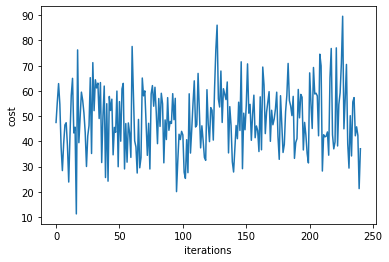

In [26]:
plt.ylabel('cost')
plt.xlabel('iterations')
plt.plot(cost)